# Compute mistakenness

### Init fiftyone

In [1]:
import os
from pathlib import Path
config_path = Path.home() / ".fiftyone" / "config.global_mongodb.json"
os.environ["FIFTYONE_CONFIG_PATH"] = str(config_path)

In [2]:
import fiftyone as fo
fo.list_datasets()

['16BIT8BIT_DATASET',
 '2024.04.10.13.33.17',
 'ALIGNED_DS_NAT',
 'HENSOLDT',
 'OUTSOURCE_SEG_ANNOTATIONS',
 'PANOPTIC_DATASET_OPT110k',
 'SAILING_DATASET',
 'SAILING_DATASET_07_03_2025',
 'SAILING_DATASET_QA',
 'SAILING_PANOPTIC_DATASET_QA',
 'SAILING_TMP_83',
 'SAM_TRACK_DATASET',
 'SAM_TRACK_IMAGES',
 'SAM_TRACK_KEY_FRAMES_DATASET',
 'SEGMENTATION_DATASET',
 'SEGMENTATION_DATASET_CURATED_MS',
 'SEGMENTATION_DATASET_PRE_ANNOTATED',
 'SEGMENT_BB_DATASET',
 'SENTRY_16BIT8BIT_DATASET',
 'SENTRY_IMAGES_SUBSAMPLE',
 'SENTRY_PANOPTIC_DATASET_QA',
 'SENTRY_SPLIT_VIDEOS_DATASET',
 'SENTRY_VIDEOS_DATASET_ALL',
 'SENTRY_VIDEOS_DATASET_QA',
 'TRAIN_PANOPTIC_DATASET',
 'TRAIN_PANOPTIC_OPTIMIZED_NAT',
 'TRAIN_PANOPTIC_OPTIMIZED_SR10',
 'TRAIN_RL_SPLIT_THERMAL_2023_11',
 'TRAIN_RL_SPLIT_THERMAL_2024_03',
 'TRAIN_THERMAL_DATASET_2023_06']

### Launch app

In [3]:
dataset_name = "TRAIN_RL_SPLIT_THERMAL_2024_03"
dataset = fo.load_dataset(dataset_name)
session = fo.launch_app(dataset=dataset, port=2203, address="127.0.0.1", auto=False)
session.show()


Could not connect session, trying again in 10 seconds

Session launched. Run `session.show()` to open the App in a cell output.


RuntimeError: Client is not connected

### Cast labels to classes used by prediction model (yolov5)

The class_map.yaml file can be found here: https://github.com/SEA-AI/yolov5/blob/sea.ai/data/class_map.yaml

In [20]:
import yaml 

def load_class_map(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
def cast_label(label, cast_dict):
    if label in cast_dict:
        return cast_dict[label]
    return label
    
class_map = load_class_map("class_map.yaml")

print("Test: HUMAN_IN_WATER -->", cast_label("HUMAN_IN_WATER", class_map))


Test: HUMAN_IN_WATER --> HUMAN


In [7]:
dataset = fo.load_dataset(dataset_name)

for sample in dataset.iter_samples(progress=True):
    
    detections_list = []

    if sample.ground_truth_det is not None:

        for det in sample.ground_truth_det.detections:

            label = cast_label(det.label, class_map)
            if label == "None":
                continue
            
            detection = fo.Detection(label=label, bounding_box=det.bounding_box, index=det.index)

            detections_list.append(detection)
    
    det_list = fo.core.labels.Detections(detections=detections_list)
    sample["ground_truth_det_cast"] = det_list
    sample.save()
dataset.save()

   0% ||--------------|    0/1000 [3.5ms elapsed, ? remaining, ? samples/s] 

 100% |███████████████| 1000/1000 [2.5s elapsed, 0s remaining, 414.3 samples/s]      


### Make predictions

In [9]:
import yolov5
import cv2

model = yolov5.load('SEA-AI/yolov5n-IR')

model.conf = 0.1  # NMS confidence threshold
model.iou = 0.1  # NMS IoU threshold
model.agnostic = True  # NMS class-agnostic

dataset_name = "TRAIN_RL_SPLIT_THERMAL_2024_03"
dataset = fo.load_dataset(dataset_name)

for sample in dataset.iter_samples(progress=True):

    if "ADDED_YOLO_PREDICTION" in sample.tags:
        continue

    frame = cv2.imread(sample.filepath)
    h, w, _ = frame.shape
    results = model(frame, size=640)

    detections = []
    for *box, conf, cls in results.xyxy[0]:
        # FiftyOne expects [top-left-x, top-left-y, width, height] normalized to [0, 1]
        x1, y1, x2, y2 = box
        rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
        detections.append(
            fo.Detection(
                label=model.names[int(cls)],
                bounding_box=rel_box,
                confidence=conf,
            )
        )

    det_list = fo.core.labels.Detections(detections=detections)
    sample["yolo_prediction"] = det_list
    sample.tags.append("ADDED_YOLO_PREDICTION")
    sample.save()
    
dataset.save()

 100% |███████████████| 1000/1000 [5.0m elapsed, 0s remaining, 3.5 samples/s]      


### Compute mistakenness

In [ ]:
import fiftyone.brain as fob

# Add this field to prevent cast issued when calculating mistakenness (otherwise the mistakeness score will possibly be casted to integers)
dataset.add_sample_field("mistakenness", fo.FloatField)

"""
    To customize the default settings for mistakenness computation, update the values in the mistakenness.py file located in the fiftyone.brain module:
    (fiftyone/brain/internal/core/mistakenness.py lines 34-35)

    _MISSED_CONFIDENCE_THRESHOLD = 0.70  # Threshold for detection confidence to be considered as missed
    _DETECTION_IOU = 0.2  # Threshold for Intersection over Union (IoU) to consider a detection as a match
"""

fob.compute_mistakenness(dataset, pred_field="yolo_prediction", label_field="ground_truth_det_cast")


### Add mistakenness_loc on sample level

In [26]:
def add_mistakenness_loc_metric(dataset, ground_truth_det="ground_truth_det"):
    # Specify field as float to prevent cast issues
    dataset.add_sample_field("mistakenness_loc", fo.FloatField)

    # Loop through samples
    for sample in dataset:
        detections = sample[ground_truth_det]

        # Extract the mistakenness_loc values from detections
        mistakenness_loc_values = [
            det.mistakenness_loc for det in detections.detections if hasattr(det, "mistakenness_loc")
        ]

        # Assign the maximum mistakenness_loc to the sample field, or -1.0 if there are no detections
        sample["mistakenness_loc"] = max(mistakenness_loc_values, default=-1.0)
        sample.save()
    dataset.save()

# Example call
add_mistakenness_loc_metric(dataset, ground_truth_det="ground_truth_det_cast")

### Sort by mistakenness

In [27]:
mistakenness_view = dataset.sort_by("mistakenness", reverse=True)
session.view = mistakenness_view

### Sort by mistakenness_loc

In [ ]:
mistakenness_view = dataset.sort_by("mistakenness_loc", reverse=True)
session.view = mistakenness_view

### Delete mistakenness metrics

In [ ]:
dataset.delete_sample_field("mistakenness_loc")
dataset.delete_brain_run("mistakenness")
dataset.delete_evaluations()

## Evaluate mistakenness metric

In [28]:
from fiftyone import ViewField as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Assuming `dataset` and `agg` are defined elsewhere

# Aggregate mistakenness and mistakenness_loc scores by label
label_scores = defaultdict(lambda: {"mistakenness": [], "mistakenness_loc": []})

for sample in tqdm(dataset):
    mistakenness = [det.mistakenness for det in sample.ground_truth_det_yolo.detections if hasattr(det, "mistakenness")]
    mistakenness_loc = [det.mistakenness_loc for det in sample.ground_truth_det_yolo.detections if hasattr(det, "mistakenness_loc")]
    
    for label, mist, loc in zip([det.label for det in sample.ground_truth_det_yolo.detections if hasattr(det, "mistakenness")],
                                mistakenness, mistakenness_loc):
        label_scores[label]["mistakenness"].append(mist)
        label_scores[label]["mistakenness_loc"].append(loc)


100%|██████████| 262289/262289 [25:18<00:00, 172.73it/s] 


### Histograms per class

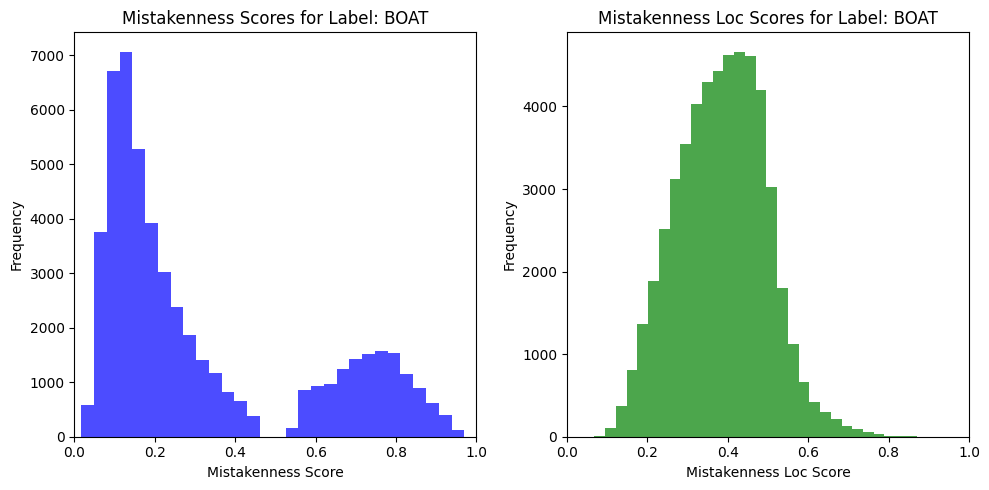

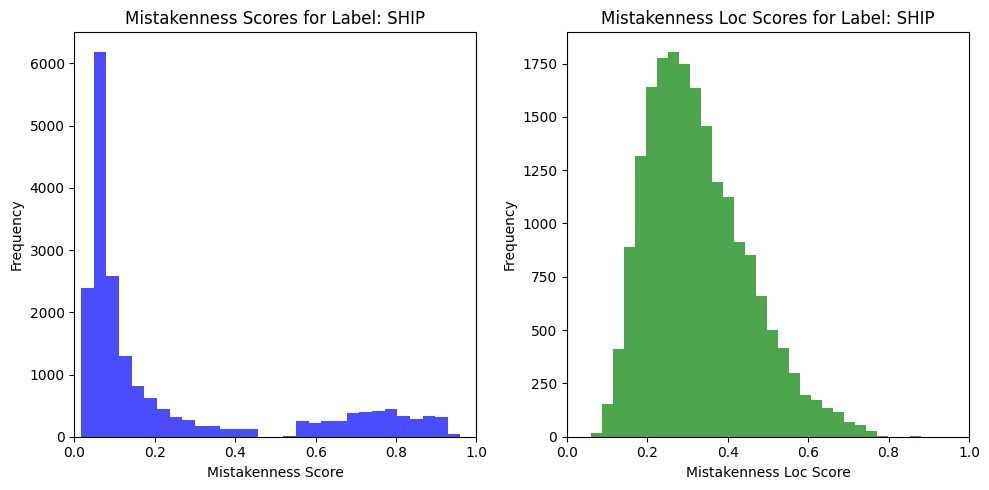

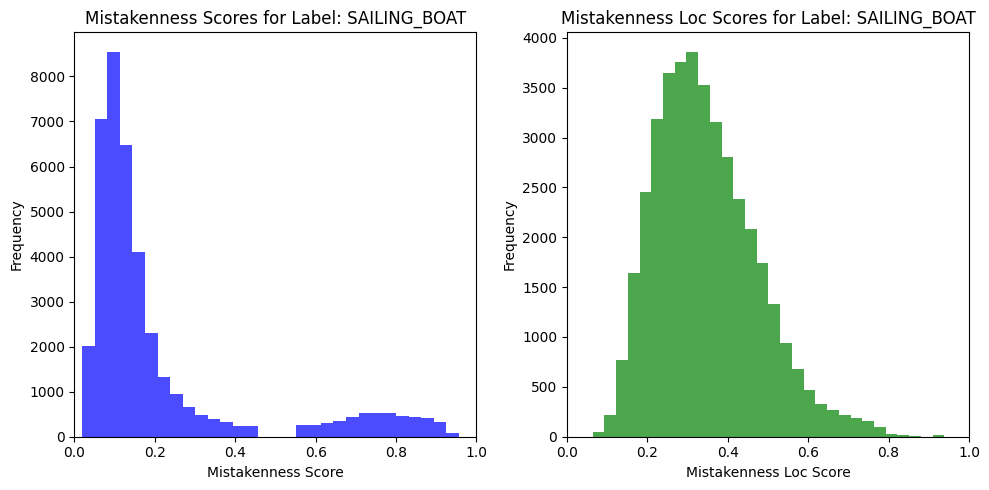

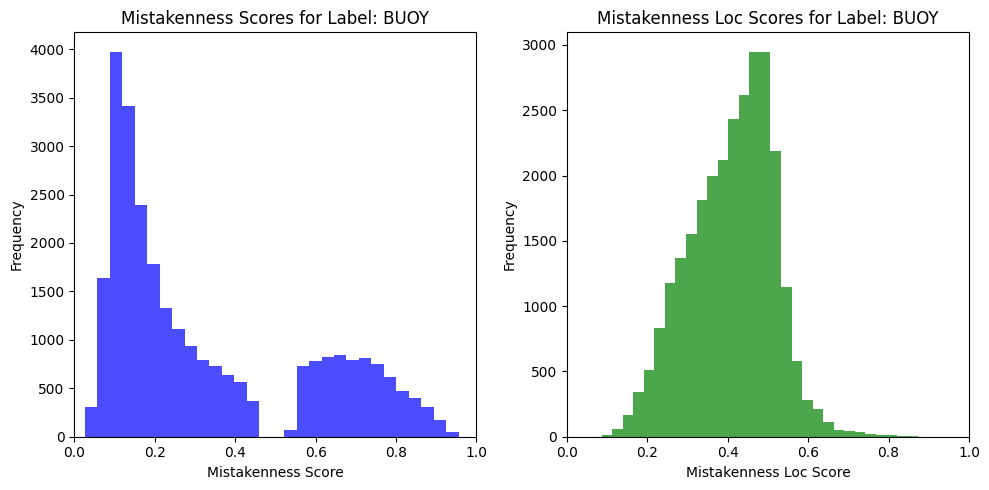

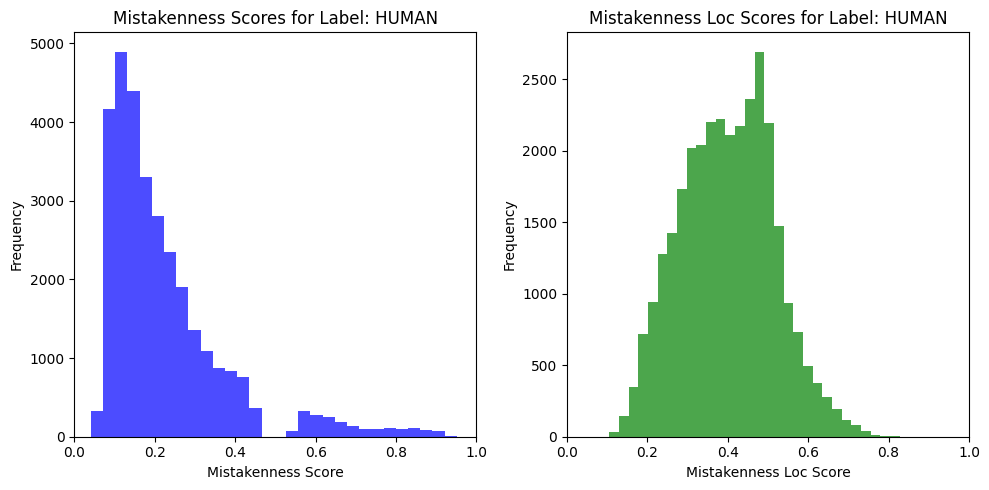

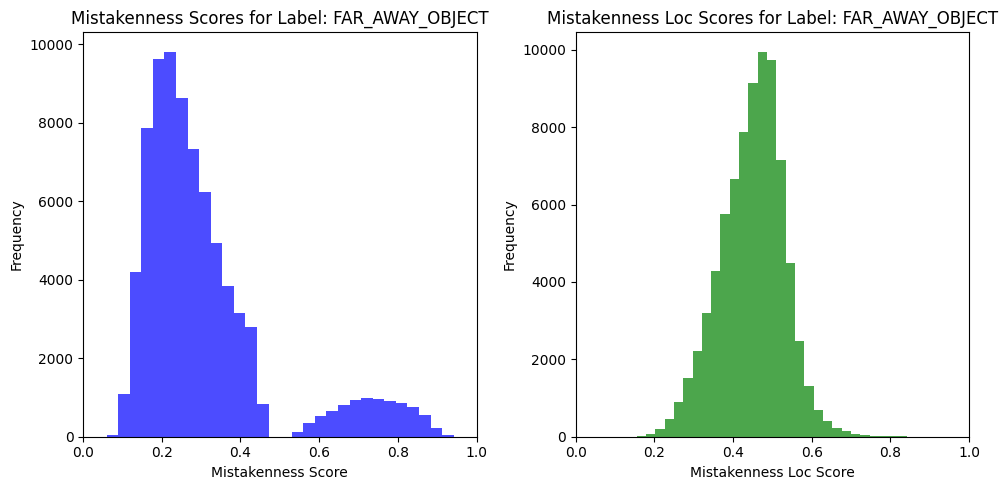

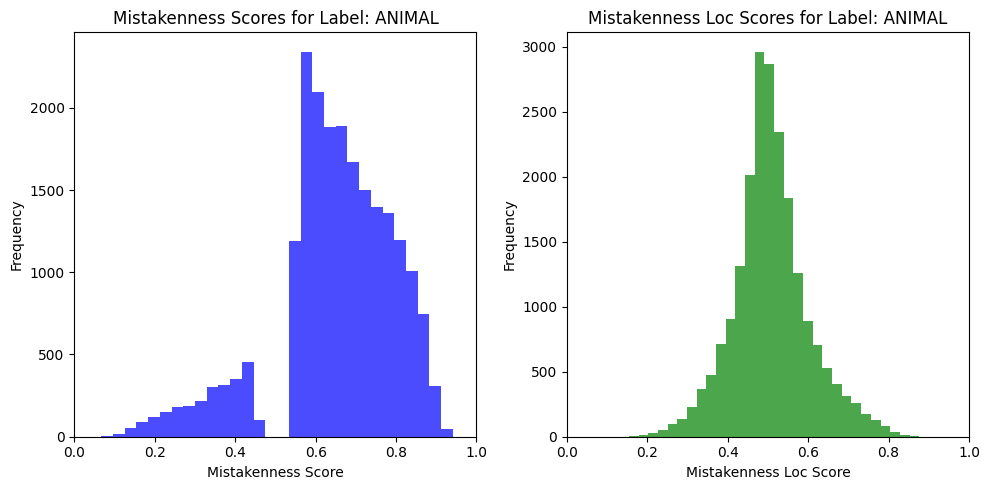

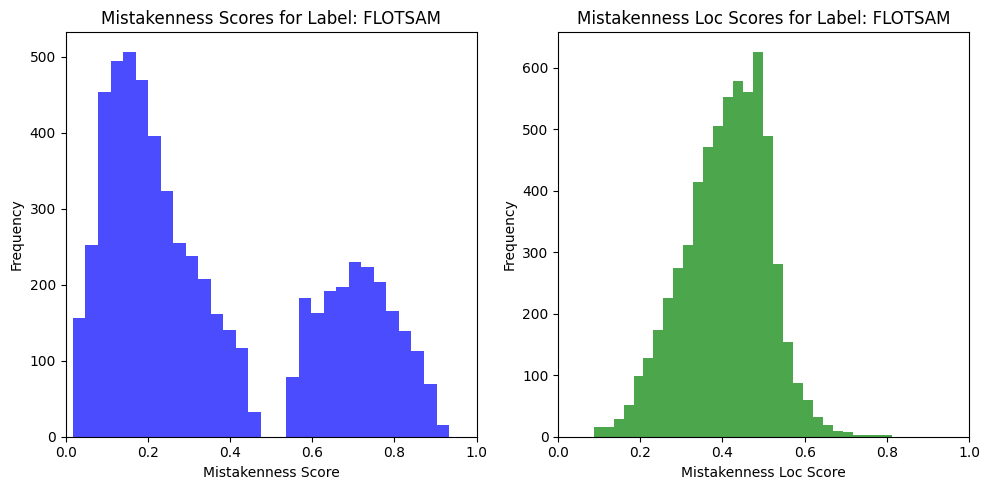

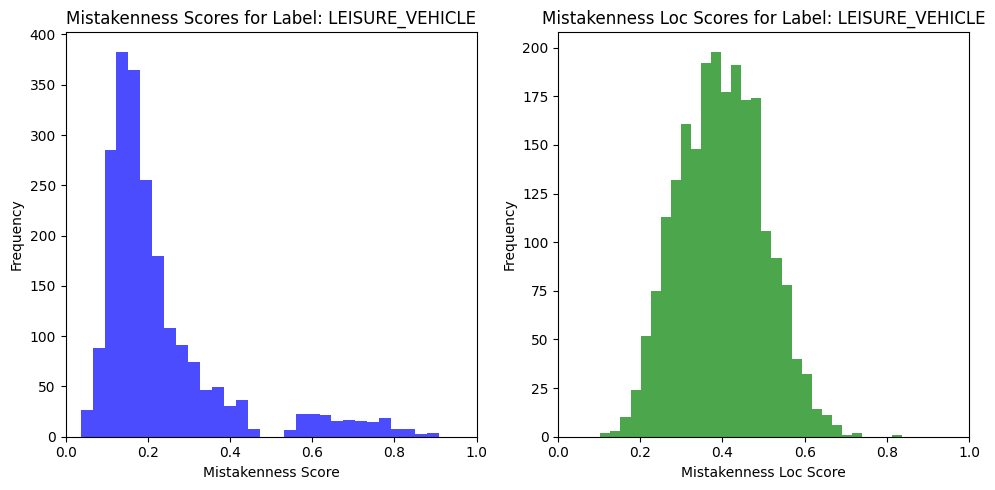

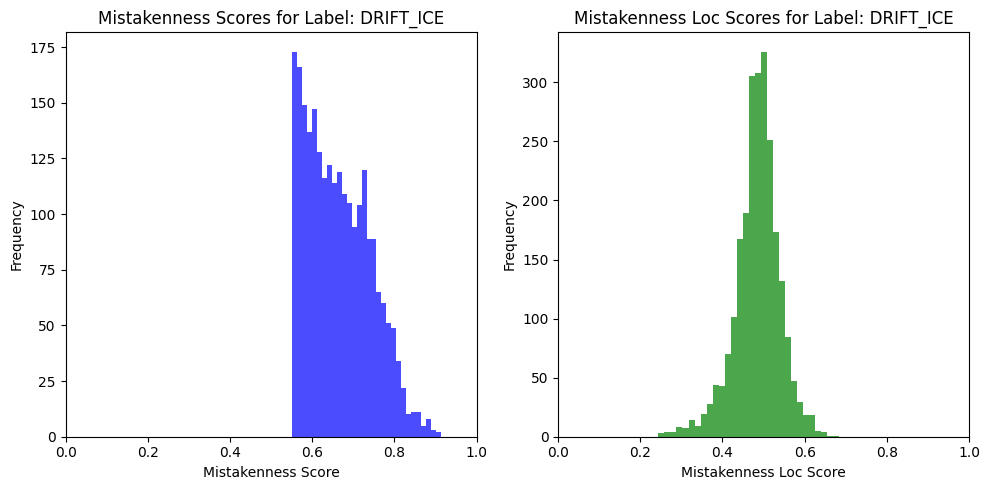

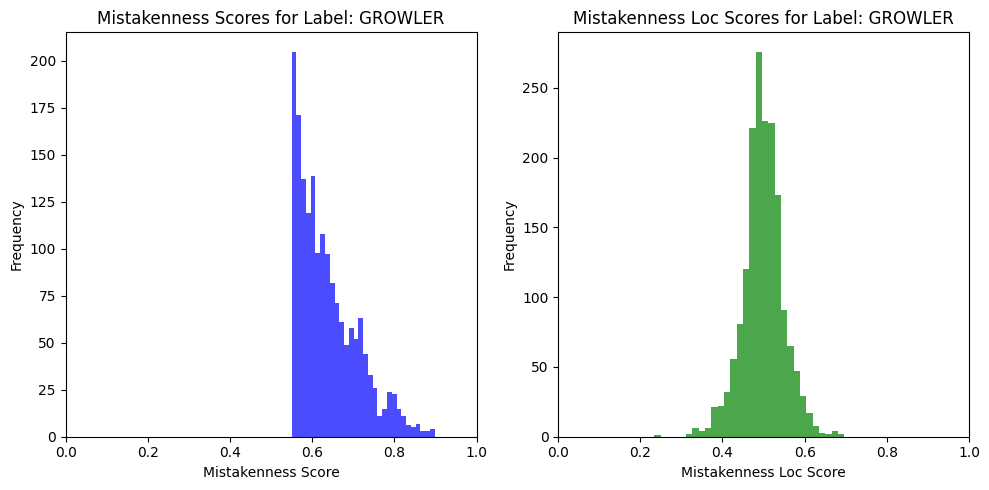

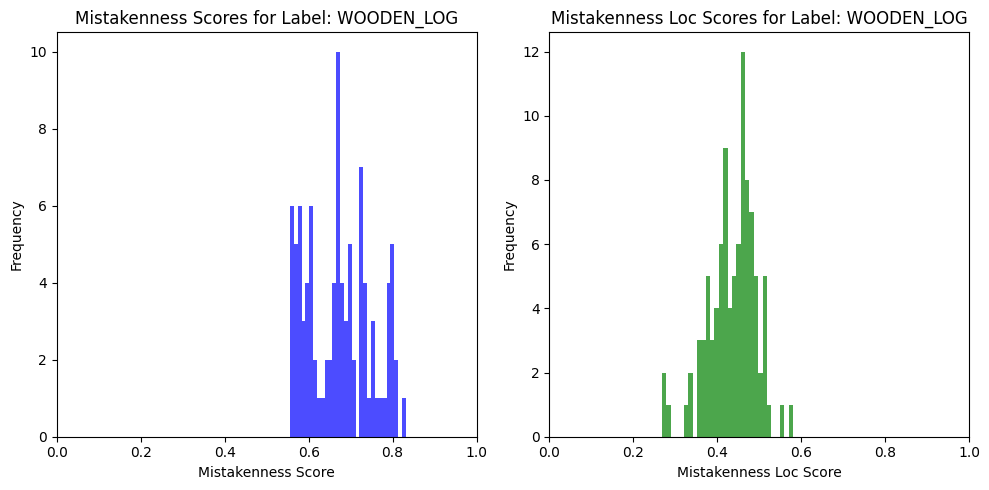

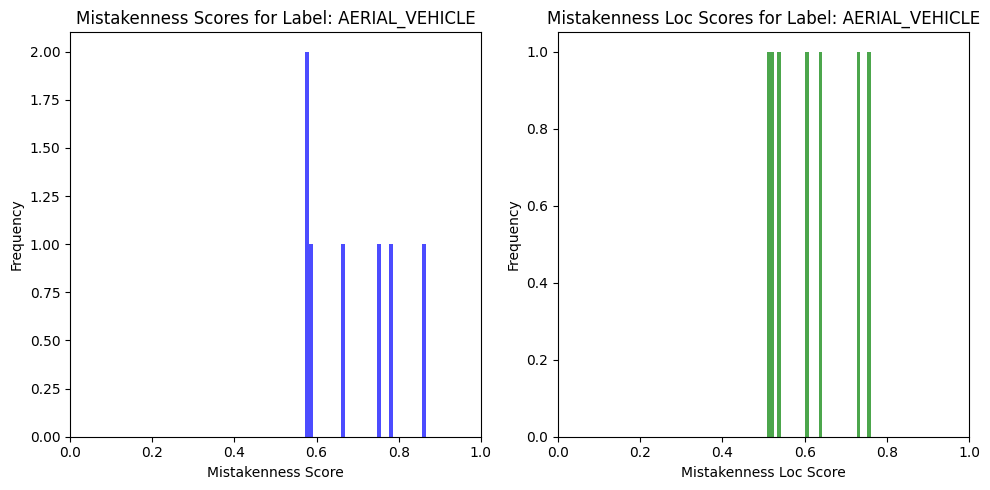

In [33]:
# Plot histograms for each label


for label, scores in label_scores.items():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot mistakenness histogram
    axs[0].hist(scores["mistakenness"], bins=30, alpha=0.7, color='blue')
    axs[0].set_title('Mistakenness Scores for Label: ' + label)
    axs[0].set_xlabel('Mistakenness Score')
    axs[0].set_ylabel('Frequency')
    axs[0].set_xlim(0, 1)  # Set x-axis range to 0-1

    # Plot mistakenness_loc histogram
    axs[1].hist(scores["mistakenness_loc"], bins=30, alpha=0.7, color='green')
    axs[1].set_title('Mistakenness Loc Scores for Label: ' + label)
    axs[1].set_xlabel('Mistakenness Loc Score')
    axs[1].set_ylabel('Frequency')
    axs[1].set_xlim(0, 1)  # Set x-axis range to 0-1

    plt.tight_layout()
    plt.show()
        

### Statistics (mean, median, std, q1, q3)

In [35]:
import numpy as np
# Dictionary to store summary statistics for each class
summary_statistics = {}

for label, scores in label_scores.items():
    # Calculate summary statistics for mistakenness scores
    mistakenness = np.array(scores["mistakenness"])
    mean_mistakenness = np.mean(mistakenness)
    median_mistakenness = np.median(mistakenness)
    std_mistakenness = np.std(mistakenness)
    q1_mistakenness = np.percentile(mistakenness, 25)
    q3_mistakenness = np.percentile(mistakenness, 75)
    
    # Store summary statistics in the dictionary
    summary_statistics[label] = {
        "mean": mean_mistakenness,
        "median": median_mistakenness,
        "std": std_mistakenness,
        "q1": q1_mistakenness,
        "q3": q3_mistakenness
    }

# Print summary statistics for each class
for label, stats in summary_statistics.items():
    print("Class:", label)
    print("Mean:", stats["mean"])
    print("Median:", stats["median"])
    print("Standard Deviation:", stats["std"])
    print("Q1 (25th Percentile):", stats["q1"])
    print("Q3 (75th Percentile):", stats["q3"])
    print()

Class: BOAT
Mean: 0.318876956950632
Median: 0.19798821210861206
Standard Deviation: 0.2618307064861613
Q1 (25th Percentile): 0.12082616984844208
Q3 (75th Percentile): 0.5624294755980372

Class: SHIP
Mean: 0.23527317467988904
Median: 0.09101030230522156
Standard Deviation: 0.27265511644824636
Q1 (25th Percentile): 0.059454500675201416
Q3 (75th Percentile): 0.27097275853157043

Class: SAILING_BOAT
Mean: 0.2085288927704803
Median: 0.1232280433177948
Standard Deviation: 0.21863888074314033
Q1 (25th Percentile): 0.08544083684682846
Q3 (75th Percentile): 0.19898416846990585

Class: BUOY
Mean: 0.330742056918839
Median: 0.21771341562271118
Standard Deviation: 0.2508665501987412
Q1 (25th Percentile): 0.1264188587665558
Q3 (75th Percentile): 0.5800255872309208

Class: HUMAN
Mean: 0.22462198730542124
Median: 0.1793437898159027
Standard Deviation: 0.1519330520831377
Q1 (25th Percentile): 0.12055307626724243
Q3 (75th Percentile): 0.27223725616931915

Class: FAR_AWAY_OBJECT
Mean: 0.3086855705637156


### Class rank

In [36]:
# Calculate mean mistakenness score for each class
class_mistakenness_mean = {label: np.mean(scores["mistakenness"]) for label, scores in label_scores.items()}

# Sort classes based on mean mistakenness score in descending order
ranked_classes = sorted(class_mistakenness_mean.items(), key=lambda x: x[1], reverse=True)

# Print ranked classes
print("Ranked Classes based on Mean Mistakenness Score:")
for i, (label, mean_mistakenness) in enumerate(ranked_classes, start=1):
    print(f"{i}. Class {label}: Mean Mistakenness Score = {mean_mistakenness:.2f}")


Ranked Classes based on Mean Mistakenness Score:
1. Class AERIAL_VEHICLE: Mean Mistakenness Score = 0.68
2. Class WOODEN_LOG: Mean Mistakenness Score = 0.67
3. Class DRIFT_ICE: Mean Mistakenness Score = 0.66
4. Class ANIMAL: Mean Mistakenness Score = 0.65
5. Class GROWLER: Mean Mistakenness Score = 0.64
6. Class FLOTSAM: Mean Mistakenness Score = 0.37
7. Class BUOY: Mean Mistakenness Score = 0.33
8. Class BOAT: Mean Mistakenness Score = 0.32
9. Class FAR_AWAY_OBJECT: Mean Mistakenness Score = 0.31
10. Class SHIP: Mean Mistakenness Score = 0.24
11. Class LEISURE_VEHICLE: Mean Mistakenness Score = 0.23
12. Class HUMAN: Mean Mistakenness Score = 0.22
13. Class SAILING_BOAT: Mean Mistakenness Score = 0.21


### Boxplots and Violinplots

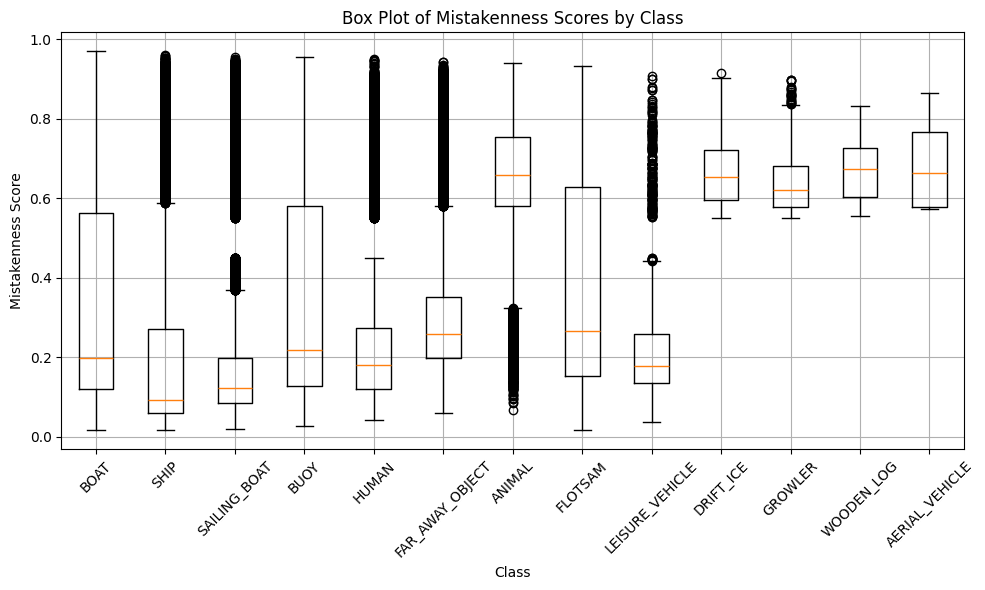

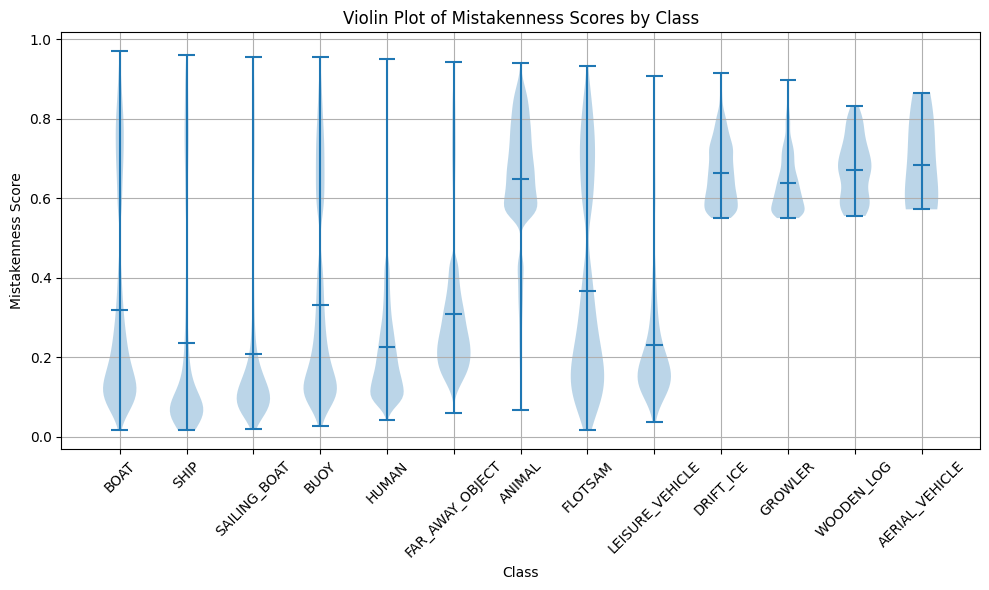

In [37]:
import matplotlib.pyplot as plt

# List to store mistakenness scores for each class
mistakenness_scores_by_class = []

# Populate mistakenness scores for each class
for label, scores in label_scores.items():
    mistakenness_scores_by_class.append(scores["mistakenness"])

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot(mistakenness_scores_by_class, labels=label_scores.keys())
plt.title('Box Plot of Mistakenness Scores by Class')
plt.xlabel('Class')
plt.ylabel('Mistakenness Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Create violin plot
plt.figure(figsize=(10, 6))
plt.violinplot(mistakenness_scores_by_class, showmeans=True)
plt.xticks(range(1, len(label_scores) + 1), label_scores.keys())
plt.title('Violin Plot of Mistakenness Scores by Class')
plt.xlabel('Class')
plt.ylabel('Mistakenness Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
